In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
# import all csvs
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

# Perform Data Exporation

In [51]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [52]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [53]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [54]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [55]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Inspect Data & Find Anomolies

<AxesSubplot:>

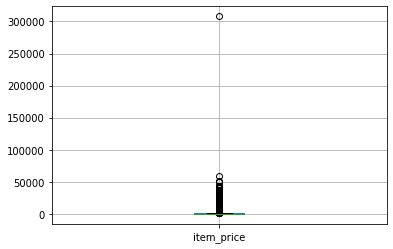

In [56]:
# This box plot shows distinct outliers (e.g., > 10000, < 0)
sales.boxplot(column=['item_price'])

In [57]:
# correct the anomolies
lessthanzero = sales[sales.item_price <= 0]
lessthanzero.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [58]:
sales_train = sales[(sales.item_price > 0) & (sales.item_price < 300000)]

<AxesSubplot:>

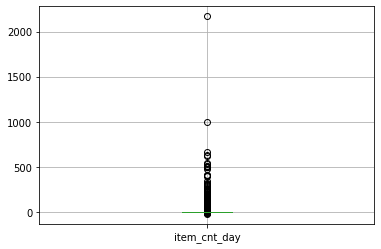

In [59]:
# This box plot shows distinct outliers (e.g., > 750, < 0) - where < 0 may be thought of as returns/refunds
sales_train.boxplot(column=['item_cnt_day'])

In [60]:
sales_train = sales_train[sales_train.item_cnt_day < 750]

<AxesSubplot:>

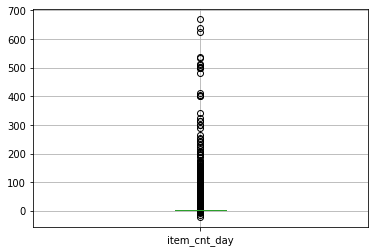

In [61]:
sales_train.boxplot(column=['item_cnt_day'])

# Items Data Prep. & Feature Engineering

In [62]:
pd.options.display.max_rows = 1000
item_categories.head(100)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [63]:
# merge items and item_categories data set on 'item_category_id' to begin crafting
# complete data set
items = pd.merge(items, item_categories, on='item_category_id')
items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [64]:
# generate a feature called 'genre' to categorize into categories and subcategories
items['genre'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино


In [65]:
# adjust some anomolies in the dataset and re-perform feature computation
manual_genre_edit = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители', #Blank Media
            'PC ': 'Аксессуары', ## PC -> Accessories
            'Служебные': 'Служебные ' #Service
            }


items['genre'] = items['genre'].apply(lambda x: manual_genre_edit[x] if x in manual_genre_edit.keys() else x)

In [66]:
# OneHotEncoding - take categories and convert them to numerical data
items['genre_id'] = LabelEncoder().fit_transform(items['genre'])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre,genre_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,11
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,11
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,11
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,11
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,11


In [67]:
items = items[['item_id', 'item_category_id', 'genre_id']]
items.head()

,item_id,item_category_id,genre_id
0,0,40,11
1,2,40,11
2,3,40,11
3,4,40,11
4,5,40,11


In [68]:
# inspect shops
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [69]:
# correct duplicate shops
# - access a group of rows and columns by labels
sales_train.loc[sales_train.shop_id == 57, 'shop_id'] = 0
sales_train.loc[sales_train.shop_id == 58, 'shop_id'] = 1
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40

test.loc[test.shop_id == 57, 'shop_id'] = 0
test.loc[test.shop_id == 58, 'shop_id'] = 1
test.loc[test.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 39, 'shop_id'] = 40

In [70]:
# begin adding sales train info
# we want to aggregate all the sales count by month instead of days so that we can view trends in the dataset

# ('date_block_num','shop_id','item_id') provides a unique primary key 
aggregate_count = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
aggregate_count.columns = ['item_cnt_month']
aggregate_count.reset_index(inplace=True)

aggregate_count.head()    

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [71]:
# NOTE - IS THIS STILL NEEDED?
#aggregate_days_sold = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']})
#aggregate_days_sold.columns = ['days_sold']
#aggregate_days_sold.reset_index(inplace=True)
#aggregate_days_sold.head() 

#cc = aggregate_days_sold.loc[aggregate_days_sold['days_sold'] > 31]
#cc.head()

In [72]:
# now that we have the total monthly sales,
# we want to determine average price per month

aggregate_price = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
aggregate_price.columns = ['mean_price']
aggregate_price.reset_index(inplace=True)

aggregate_price.head()

,date_block_num,shop_id,item_id,mean_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [75]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales_train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))


df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)


#Add month sales
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=index_cols, how='left')
df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))
df.head(5)

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


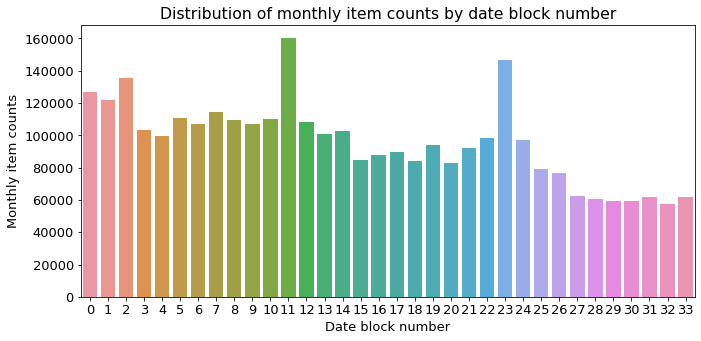

In [76]:
# plot item counts against each month (0-33 months)
# we can see how months 11 + 23 (December) show a spike in sales
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
# group by date, provide sum of item count
upscale = df.copy()
upscale['item_cnt_month'] = upscale['item_cnt_month'].astype(np.float32)

group_month_sum = upscale.groupby(['date_block_num']).agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

del group_month_sum
del upscale

In [78]:
# NOTE IS THIS STILL NEEDED?
merged = df #aggregate_count.merge(aggregate_price, on=['date_block_num','shop_id','item_id'], how='left')
merged.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [80]:
# append to test data set & set data types
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
# concatenate current dataset and test dataset
merged = pd.concat([merged, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merged.fillna(0, inplace=True)


In [81]:
# confirm test set that we created
mx = merged.loc[merged['date_block_num'] == 34]
print(len(mx))
mx.head()
print(len(test))


214200
214200


In [82]:
merged2 = merged.merge(items, on=['item_id'], how='left')
merged2.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_id,genre_id
0,59,22154,0,1.0,0.0,37,11
1,59,2552,0,0.0,0.0,58,13
2,59,2554,0,0.0,0.0,58,13
3,59,2555,0,0.0,0.0,56,13
4,59,2564,0,0.0,0.0,59,13


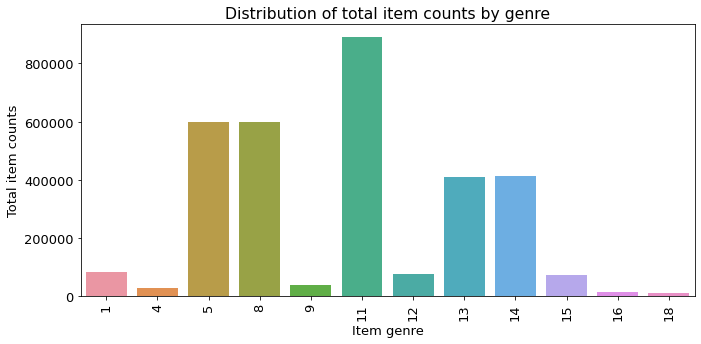

In [85]:
# here, we plot the distribution of total item counts by genre

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
upscale = merged2.copy()
upscale['item_cnt_month'] = upscale['item_cnt_month'].astype(np.float32)
group_cat_sum = upscale.groupby('genre_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='genre_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by genre',
       xlabel='Item genre', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

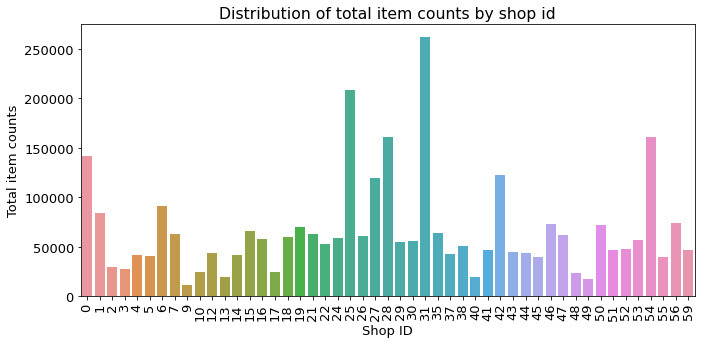

In [87]:
# plot distribution of total item counts by shop ID

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
upscale = merged2.copy()
upscale['item_cnt_month'] = upscale['item_cnt_month'].astype(np.float32)
group_shop_sum = upscale.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

In [88]:
# normalize month into 1-12 format instead of 0-33
merged2["month_id"] = merged2['date_block_num'].apply(lambda dbn: 1 + dbn % 12)
merged2.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_id,genre_id,month_id
0,59,22154,0,1.0,0.0,37,11,1
1,59,2552,0,0.0,0.0,58,13,1
2,59,2554,0,0.0,0.0,58,13,1
3,59,2555,0,0.0,0.0,56,13,1
4,59,2564,0,0.0,0.0,59,13,1


In [89]:
month_inspection = sales_train.loc[sales_train["date_block_num"] == 5]
month_inspection = month_inspection.groupby(['date']).agg({'item_cnt_day': ['sum']})
month_inspection = month_inspection.reset_index()

month_inspection["date"] = month_inspection['date'].apply(lambda x: int(x.split('.')[0]) )
month_inspection.head(5)

,date,item_cnt_day
,,sum
0,1,5734.0
1,2,4486.0
2,3,3239.0
3,4,3247.0
4,5,3418.0


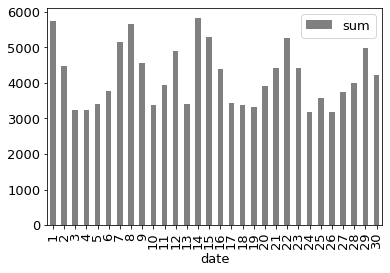

In [90]:
# here, we are able to see that weekends correlate with more sales.
month_inspection.plot.bar(x="date", y="item_cnt_day", color='grey');

In [91]:
# given a month, compute the number of weekends so that we can use as an additional feature
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    return weeknd_count
map_dict = {i: count_days(i) for i in range(35)}

merged2['weeknd_count'] = merged2['date_block_num'].apply(lambda x: map_dict[x])
merged2.head()

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_id,genre_id,month_id,weeknd_count
0,59,22154,0,1.0,0.0,37,11,1,4
1,59,2552,0,0.0,0.0,58,13,1,4
2,59,2554,0,0.0,0.0,58,13,1,4
3,59,2555,0,0.0,0.0,56,13,1,4
4,59,2564,0,0.0,0.0,59,13,1,4


In [92]:
# lagging is a critical feature for our training process.
# it allows for model to look back in time and see how the shop performed in the months before.
# currently, we are looking up to 3 months back
def lag_feature(df, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in [1, 2, 3]:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    del tmp
    return df

In [93]:
merged2 = lag_feature(merged2, 'item_cnt_month')
merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']] = merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].fillna(value=0)

In [94]:
# let's take a look here and now we can see we have counts for the number of items sold
# 1 month before, 2 months before, and 3.
merged2.head(500000)

,shop_id,item_id,date_block_num,item_cnt_month,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,59,22154,0,1.0,0.0,37,11,1,4,0.0,0.0,0.0
1,59,2552,0,0.0,0.0,58,13,1,4,0.0,0.0,0.0
2,59,2554,0,0.0,0.0,58,13,1,4,0.0,0.0,0.0
3,59,2555,0,0.0,0.0,56,13,1,4,0.0,0.0,0.0
4,59,2564,0,0.0,0.0,59,13,1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
499995,15,13755,1,0.0,0.0,57,13,2,4,0.0,0.0,0.0
499996,15,13067,1,0.0,0.0,40,11,2,4,0.0,0.0,0.0
499997,15,13756,1,0.0,0.0,41,11,2,4,0.0,0.0,0.0
499998,15,13757,1,0.0,0.0,41,11,2,4,0.0,0.0,0.0


In [95]:
# create final dataset
# split data into training validation and testing
# we originally put them all together to make feature engineering easier
X_train = merged2[(merged2.date_block_num >= 3) & (merged2.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = merged2[(merged2.date_block_num >= 3) & (merged2.date_block_num < 33)]['item_cnt_month']

X_valid = merged2[merged2.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = merged2[merged2.date_block_num == 33]['item_cnt_month']

X_test = merged2[merged2.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [96]:
# begin training using lgb
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'item_category_id',
                        'genre_id',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
# light gradient boosted machine
# uses decision tree ensemble - weak learner becomes gradient boosting tree
gbm = lgb.train(
        params, 
        lgb_train, # data to be trained on
        num_boost_round=3000, # boosting iterations
        valid_sets=(lgb_train, lgb_eval),  # data to be evaluted on
        feature_name = feature_name, # define numerical features
        categorical_feature = feature_name_indexes, # define categorical features
        verbose_eval=5,  #print eval metric on every boosting iteration
        evals_result = evals_result, # where to store eval results
        early_stopping_rounds = 100
)

/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['genre_id', 'item_category_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.184453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 9481110, number of used features: 10
[LightGBM] [Info] Start training from score 0.296229


/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[5]	training's rmse: 1.20515	valid_1's rmse: 1.12892
[10]	training's rmse: 1.19499	valid_1's rmse: 1.12161
[15]	training's rmse: 1.18477	valid_1's rmse: 1.11448
[20]	training's rmse: 1.17423	valid_1's rmse: 1.10709
[25]	training's rmse: 1.16409	valid_1's rmse: 1.0999
[30]	training's rmse: 1.15486	valid_1's rmse: 1.09354
[35]	training's rmse: 1.14654	valid_1's rmse: 1.08766
[40]	training's rmse: 1.13743	valid_1's rmse: 1.08159
[45]	training's rmse: 1.12913	valid_1's rmse: 1.07578
[50]	training's rmse: 1.12167	valid_1's rmse: 1.07064
[55]	training's rmse: 1.11394	valid_1's rmse: 1.06556
[60]	training's rmse: 1.10609	valid_1's rmse: 1.06037
[65]	training's rmse: 1.09853	valid_1's rmse: 1.05529
[70]	training's rmse: 1.09181	valid_1's rmse: 1.05064
[75]	training's rmse: 1.08516	valid_1's rmse: 1.0462
[80]	training's rmse: 1.07843	valid_1's rmse: 1.04164
[85]	training's rmse: 1.07232	valid_1's rmse: 1.03765
[90]	training's rmse: 1

[730]	training's rmse: 0.899816	valid_1's rmse: 0.945822
[735]	training's rmse: 0.899594	valid_1's rmse: 0.945811
[740]	training's rmse: 0.89941	valid_1's rmse: 0.945762
[745]	training's rmse: 0.899217	valid_1's rmse: 0.945645
[750]	training's rmse: 0.89903	valid_1's rmse: 0.945541
[755]	training's rmse: 0.89884	valid_1's rmse: 0.945442
[760]	training's rmse: 0.898629	valid_1's rmse: 0.945402
[765]	training's rmse: 0.898416	valid_1's rmse: 0.945364
[770]	training's rmse: 0.898208	valid_1's rmse: 0.945413
[775]	training's rmse: 0.898013	valid_1's rmse: 0.9454
[780]	training's rmse: 0.897773	valid_1's rmse: 0.945256
[785]	training's rmse: 0.89757	valid_1's rmse: 0.945215
[790]	training's rmse: 0.89737	valid_1's rmse: 0.945161
[795]	training's rmse: 0.897167	valid_1's rmse: 0.945124
[800]	training's rmse: 0.896958	valid_1's rmse: 0.94507
[805]	training's rmse: 0.896759	valid_1's rmse: 0.945099
[810]	training's rmse: 0.896565	valid_1's rmse: 0.945114
[815]	training's rmse: 0.896382	valid_1

[1445]	training's rmse: 0.877437	valid_1's rmse: 0.940099
[1450]	training's rmse: 0.877347	valid_1's rmse: 0.939833
[1455]	training's rmse: 0.877249	valid_1's rmse: 0.939665
[1460]	training's rmse: 0.877159	valid_1's rmse: 0.93953
[1465]	training's rmse: 0.877026	valid_1's rmse: 0.9395
[1470]	training's rmse: 0.876922	valid_1's rmse: 0.939158
[1475]	training's rmse: 0.876819	valid_1's rmse: 0.938938
[1480]	training's rmse: 0.876708	valid_1's rmse: 0.938874
[1485]	training's rmse: 0.876628	valid_1's rmse: 0.938686
[1490]	training's rmse: 0.87649	valid_1's rmse: 0.938702
[1495]	training's rmse: 0.876378	valid_1's rmse: 0.93868
[1500]	training's rmse: 0.876284	valid_1's rmse: 0.938713
[1505]	training's rmse: 0.876177	valid_1's rmse: 0.938697
[1510]	training's rmse: 0.8761	valid_1's rmse: 0.938569
[1515]	training's rmse: 0.876007	valid_1's rmse: 0.938542
[1520]	training's rmse: 0.875862	valid_1's rmse: 0.938528
[1525]	training's rmse: 0.875721	valid_1's rmse: 0.938547
[1530]	training's rms

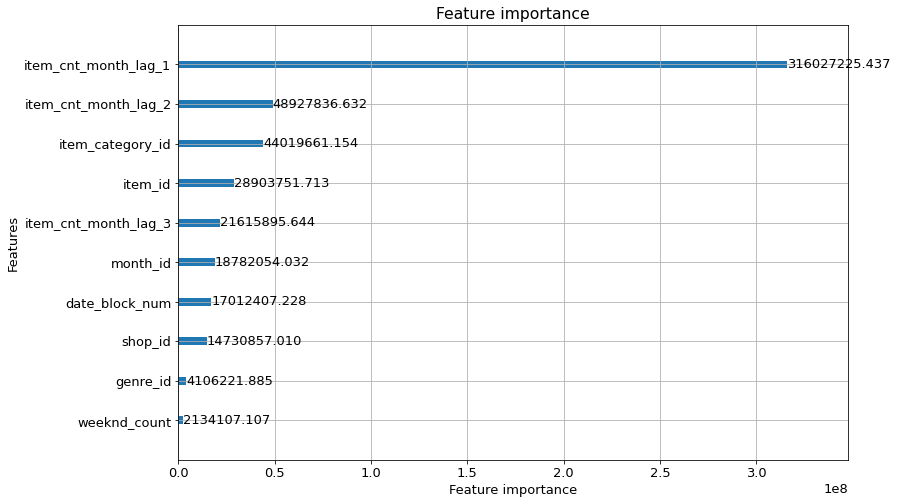

In [97]:
# plot feature significance to training
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [98]:
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)



submission = pd.DataFrame({ "ID": test.index, "item_cnt_month": Y_test }) 
submission.to_csv('gbm_submissionAG.csv', index=False)